# LSTM网络实现RNN写作生成

**任务要求：利用LSTM网络实现RNN的莎士比亚风格文本写作生成。**  
**数据: shakespeare.txt**

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import unidecode
import string
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
use_gpu = True if torch.cuda.is_available() else False
print('Use GPU:', use_gpu)

Use GPU: False


## 1. 加载文本数据

加载训练文本数据及字符集

In [3]:
all_characters = string.printable
n_characters = len(all_characters)
print('characters num:', n_characters)
print(all_characters)

file = unidecode.unidecode(open('./data/english.txt').read())
file_len = len(file)
print('file length:', file_len)

characters num: 100
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

file length: 1018


### 随机文本块

In [4]:
chunk_len = 500
#500

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index: end_index]

print(random_chunk())

a lot.
My favorite gadget is my glass hour.my glass hour is baught from a big shop,it made by wood,glass and drit.looks very cute.i always use my little glasshour to count time,the drit fell down from top ,after,5 munits it is dunk.When as time as a arrow shoot from a bow,my glass hour tell me ;time is money.i should hard to study,who use the value time.
My favorite gadget is the campus card, he has the following functions: first of all, he can let the bedroom downstairs door for me to open, seco


### 随机数据-标签对

In [8]:
def char_tensor(string):
    n = len(string)
    t = torch.zeros(n).long()
    for i in range(n):
        t[i] = all_characters.index(string[i])
    return Variable(t)
print(all_characters)
print(char_tensor('(abcdef,ABCDEF).'))

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

tensor([69, 10, 11, 12, 13, 14, 15, 73, 36, 37, 38, 39, 40, 41, 70, 75])


In [9]:
def random_training_set():
    chunk = random_chunk()
    inputs = char_tensor(chunk[:-1])
    targets = char_tensor(chunk[1:]) #每个字符到后一个字符
    return inputs, targets

random_training_set()

(tensor([94, 29, 14, 21, 21, 94, 22, 14, 94, 78, 29, 18, 22, 14, 94, 18, 28, 94,
         22, 24, 23, 14, 34, 75, 18, 94, 28, 17, 24, 30, 21, 13, 94, 17, 10, 27,
         13, 94, 29, 24, 94, 28, 29, 30, 13, 34, 73, 32, 17, 24, 94, 30, 28, 14,
         94, 29, 17, 14, 94, 31, 10, 21, 30, 14, 94, 29, 18, 22, 14, 75, 96, 48,
         34, 94, 15, 10, 31, 24, 27, 18, 29, 14, 94, 16, 10, 13, 16, 14, 29, 94,
         18, 28, 94, 29, 17, 14, 94, 12, 10, 22, 25, 30, 28, 94, 12, 10, 27, 13,
         73, 94, 17, 14, 94, 17, 10, 28, 94, 29, 17, 14, 94, 15, 24, 21, 21, 24,
         32, 18, 23, 16, 94, 15, 30, 23, 12, 29, 18, 24, 23, 28, 77, 94, 15, 18,
         27, 28, 29, 94, 24, 15, 94, 10, 21, 21, 73, 94, 17, 14, 94, 12, 10, 23,
         94, 21, 14, 29, 94, 29, 17, 14, 94, 11, 14, 13, 27, 24, 24, 22, 94, 13,
         24, 32, 23, 28, 29, 10, 18, 27, 28, 94, 13, 24, 24, 27, 94, 15, 24, 27,
         94, 22, 14, 94, 29, 24, 94, 24, 25, 14, 23, 73, 94, 28, 14, 12, 24, 23,
         13, 73, 94, 17, 14,

## 2. RNN模型

利用PyTorch构建RNN模型类，内部包括Embedding层、LSTM、FC层

In [10]:
''' 请在下方编写RNN模型类 '''

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.num_layers=num_layers
        
        self.embedding = nn.Embedding(num_embeddings=100, embedding_dim=input_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)
        
    def forward(self, inputs, hidden):
        
        o1=self.embedding(inputs.view(1,-1)) #转为2维[[]] 经过embedding后变成三维[[[]]]
        o2,(h,c)=self.lstm(o1,hidden) #返回值是 output , (h,c)  
        outputs=self.fc(o2) 
        hidden=(h,c)
        
        return outputs, hidden
    
    def init_hidden(self):
        h0= Variable(torch.zeros(self.num_layers,1,self.hidden_size))#(1,1,100)
        c0= Variable(torch.zeros(self.num_layers,1,self.hidden_size))
        return h0, c0

## 3. 训练函数

In [11]:
def train(inputs, target):
    h, c = rnn.init_hidden()
    if use_gpu:
        inputs = inputs.cuda()
        target = target.cuda()
        h, c = h.cuda(), c.cuda()
    hidden = (h, c)
    
    loss = 0
    for i in range(len(inputs)):
        ''' 请在下方编写rnn模型输出，及loss累加代码'''
        output,hidden=rnn.forward(inputs[i],hidden)

        loss+=criterion(output.view(1,100),target[i].view(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.data.item()/len(inputs)

## 4. 文本生成测试函数

In [12]:
def test(prime_str='A', predict_len=100, temperature=0.8):
    h, c = rnn.init_hidden()
    prime_input = char_tensor(prime_str)#'Th'

    if use_gpu:
        h, c = h.cuda(), c.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str
    
    for i in range(len(prime_str)-1):
        _, (h, c) = rnn(prime_input[i], (h, c))
    inputs = prime_input[-1]

    for p in range(predict_len):
        if use_gpu:
            inputs = inputs.cuda()
        output, (h, c) = rnn(inputs, (h, c))
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inputs = char_tensor(predicted_char)
    
    return predicted

## 5. 模型训练

#### 超参数

In [13]:
''' 请自行设定相关参数 '''
epoch_num = 2000  # 1000~10000
print_every = 100
plot_every = 10
hidden_size = 100
num_layers = 1
lr = 0.01

#### 模型、优化器、损失函数

In [14]:
# RNN模型
rnn = RNN(n_characters, hidden_size, n_characters, num_layers)
if use_gpu:
    rnn = rnn.cuda()
print(rnn)

RNN(
  (embedding): Embedding(100, 100)
  (lstm): LSTM(100, 100)
  (fc): Linear(in_features=100, out_features=100, bias=True)
)


In [15]:
# 优化器
''' 请在下方编写Adam优化器定义的代码 '''
optimizer = torch.optim.Adam(rnn.parameters(),lr=lr)
print(optimizer)

# 损失函数
''' 请在下方编写交叉熵损失函数定义的代码 '''
criterion = nn.CrossEntropyLoss()
print(criterion)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
CrossEntropyLoss()


#### 模型训练

In [16]:
time_start = time.time()
evaluate = True  # 可设置为False，训练过程中不评估
loss_list = []
loss_avg = 0

for epoch in range(1, epoch_num+1):
    inputs, targets = random_training_set()
    loss = train(inputs, targets)
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('[Time: %ds  Epoch: %d (%d%%)  Loss: %.4f]'%(int(time.time()-time_start), epoch, epoch/epoch_num*100, loss))
        if evaluate:
            pred_text = test('Th', 200)
            print(pred_text, '\n')
        
    if epoch % plot_every == 0:
        loss_list.append(loss_avg/plot_every)
        loss_avg = 0
# #保存模型
# torch.load(rnn,'rnn.pkl')

[Time: 21s  Epoch: 100 (5%)  Loss: 0.2153]
The the campass hour bed by woorit droovent the study, her can let the campus card, he has the card, he cant suntecis very cond, he can let the can card, he should hard to study,whoo fullet me campus ca 

[Time: 42s  Epoch: 200 (10%)  Loss: 0.0951]
Tho suntes as and pictures. I like it a lok. It's so cutell me ;tit made by wood,glass a present after I got a good score in an a run in the sun credit card, moreover, he can let the dit ellet me as a a 

[Time: 62s  Epoch: 300 (15%)  Loss: 0.0362]
Thour to count time,the drit fell down from top ,after,5 munits it is dunk.When as time as a arrow shoot from a bow,my glass hour tell me ;time is money.i should hard to study,who use the value time.
My 

[Time: 83s  Epoch: 400 (20%)  Loss: 0.0695]
Thour to oney.i should hard to study,who use the value time.
My favorite gadget is the campus card, he has the following functions: first of all, he can let me pay the bill in the canteen is very conven 

[Time

## 6. 训练Loss曲线

绘制训练过程中的Loss曲线

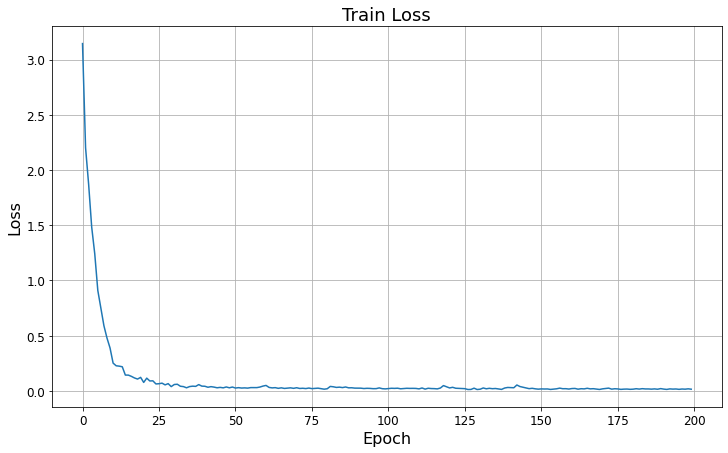

In [17]:
plt.figure(figsize=(12, 7))
plt.plot(loss_list)
plt.title('Train Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()

## 7. 测试

自定义初始字符和文本长度以生成文本

In [19]:
test_text = test('My', 1000, 0.8)
print(test_text)

My favorite gadget is my glass hour.my glass hour is baught from a big shop,it made by wood,glass and drit.looks very cute.i always use my little glasshour to count time,the drit fell down from top ,after,5 munits it is dunk.When as time as a arrow shoot from a bow,my glass hour tell me ;time is money.i should hard to study,who use the value time.
My favorite gadget is the campus card, he has the following functions: first of all, he can let the bedroom downstairs door for me to open, second, he can run in the sun credit card, moreover, he can let me pay the bill in the canteen is very convenient, finally, he can also be used as a ruler by me. I believe that not only I, as well as every college student of Hangzhou Dianzi University, will love this campus card, he has the following functions: first of all, he can let the bedroom downstairs door for me to open, second, he can run in the sun credit card, moreover, he can let me pay the bill in the canteen is very convenient, finally, he c

In [16]:
# test_text = test('Wh', 1000, 0.8)
# print(test_text)